In [2]:
### Inport Library
import pandas as pd
import numpy as np
from numpy import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import pywt

from tqdm import tqdm
import re
import pickle as pkl

import matplotlib.pyplot as plt
import h5py

import geopy
from geopy.geocoders import Nominatim

### Tools
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Load Data

## Load STEAD Indonesia Earthquake Data

In [3]:
DATA_PATH = './data/merge.csv'

df = pd.read_csv(DATA_PATH, low_memory=False)

print(f'total data: {len(df)}')
df.sample(10)

total data: 1265657


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
1147956,AK,SKN,BH,61.980000,-151.531700,581.0,706.2,autopicker,0.92,6.757000,...,None,None,0.3180,35.51,312.30,[32.70000076 19.20000076 14.5 ],[[2077.]],2016-11-05 00:50:20.628000,earthquake_local,SKN.AK_20161105005019_EV
377763,PB,B084,EH,33.611570,-116.456370,1271.0,500.0,manual,0.61,8.440000,...,CI,None,0.4501,50.05,325.20,[23.70000076 23.10000038 25.89999962],[[1767.]],2010-12-30 21:52:33.410000,earthquake_local,B084.PB_20101230215232_EV
337731,PB,B082,EH,33.598182,-116.596005,1374.8,800.0,manual,0.55,11.640000,...,CI,None,0.6270,69.73,159.90,[13.69999981 14.39999962 12.60000038],[[2634.]],2011-05-20 12:09:00.560000,earthquake_local,B082.PB_20110520120859_EV
88287,NN,DSP,HN,37.369400,-117.974100,2400.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-27 09:24:00,noise,DSP.NN_201608270924_NO
1203631,UW,TTW,BH,47.694450,-121.690110,542.0,600.0,manual,0.95,20.969999,...,UW,None,1.2470,138.57,308.70,[33.29999924 37. 30.70000076],[[5900.]],2002-09-26 07:00:19.830000,earthquake_local,TTW.UW_20020926070018_EV
382369,PB,B084,EH,33.611570,-116.456370,1271.0,392.0,autopicker,0.78,5.570000,...,CI,None,0.2996,33.31,52.30,[28.20000076 29.10000038 34.90000153],[[1837.]],2012-02-03 02:41:20.910000,earthquake_local,B084.PB_20120203024119_EV
134948,AC,LSK,HH,40.149899,20.598700,960.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 02:13:00,noise,LSK.AC_20180115021300_NO
578226,NC,BSR,EL,36.667431,-121.520325,375.0,700.0,manual,0.51,14.570000,...,NC,None,0.7667,84.93,345.50,[-0.60000002 11.89999962 7.69999981],[[3199.]],2007-11-11 17:14:22.080000,earthquake_local,BSR.NC_20071111171421_EV
918237,NN,LHV,HH,38.251300,-118.504900,2353.0,700.0,manual,0.95,9.200280,...,None,None,0.4590,50.95,331.08,[25.60000038 27. 25.70000076],[[2018.]],2015-09-18 15:56:00.815280,earthquake_local,LHV.NN_20150918155559_EV
248115,HV,AIND,HH,19.372067,-155.457228,1524.0,887.0,autopicker,0.87,4.190000,...,None,None,0.1623,18.07,87.00,[14.5 11.10000038 7. ],[[3122.]],2015-05-15 16:49:09.590000,earthquake_local,AIND.HV_20150515164908_EV


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265657 entries, 0 to 1265656
Data columns (total 35 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   network_code                      1265613 non-null  object 
 1   receiver_code                     1265657 non-null  object 
 2   receiver_type                     1265657 non-null  object 
 3   receiver_latitude                 1265657 non-null  float64
 4   receiver_longitude                1265657 non-null  float64
 5   receiver_elevation_m              1265657 non-null  float64
 6   p_arrival_sample                  1030231 non-null  float64
 7   p_status                          1030231 non-null  object 
 8   p_weight                          1030057 non-null  float64
 9   p_travel_sec                      1030231 non-null  float64
 10  s_arrival_sample                  1030231 non-null  float64
 11  s_status                          103

In [5]:
df_extract_column = df[['network_code', 'receiver_code', 'receiver_elevation_m',
                        'receiver_latitude', 'receiver_longitude',
                        'p_arrival_sample', 'p_weight', 'p_travel_sec',
                        's_arrival_sample', 's_weight',
                        'source_origin_time', 'source_origin_uncertainty_sec',
                        'source_latitude', 'source_longitude', 'source_distance_deg', 'source_distance_km',
                        'back_azimuth_deg',
                        'snr_db', 'trace_category', 'trace_name']]
print(f'shape: {df_extract_column.shape}')
df_extract_column.head()

shape: (1265657, 20)


,network_code,receiver_code,receiver_elevation_m,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,s_arrival_sample,s_weight,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201510210555_NO
1,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511061450_NO
2,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511070220_NO
3,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511140515_NO
4,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201512251850_NO


In [6]:
df_noise = df_extract_column[df_extract_column['trace_category'] == 'noise'].reset_index(drop=True)
print(f'shape: {df_noise.shape}')
df_noise.head()

shape: (235426, 20)


,network_code,receiver_code,receiver_elevation_m,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,s_arrival_sample,s_weight,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201510210555_NO
1,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511061450_NO
2,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511070220_NO
3,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511140515_NO
4,TA,109C,150.0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201512251850_NO


In [7]:
df_earthquake = df_extract_column[df_extract_column['trace_category'] == 'earthquake_local'].reset_index(drop=True)
print(f'shape: {df_earthquake.shape}')
df_earthquake.head()

shape: (1030231, 20)


,network_code,receiver_code,receiver_elevation_m,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,s_arrival_sample,s_weight,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,TA,109C,150.0,32.8889,-117.1051,700.0,0.5,17.080000,1894.0,0.5,2006-07-23 15:58:50.88,0.47,33.7496,-117.4938,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],earthquake_local,109C.TA_20060723155859_EV
1,TA,109C,150.0,32.8889,-117.1051,600.0,0.5,16.879999,1763.0,0.5,2006-11-03 15:56:42.73,0.24,32.7077,-116.0446,0.91,101.34,281.7,[65. 65.5 61.40000153],earthquake_local,109C.TA_20061103155652_EV
2,TA,109C,150.0,32.8889,-117.1051,500.0,0.5,17.260000,1678.0,0.5,2006-11-03 16:12:12.44,0.27,32.7253,-116.0348,0.92,101.87,280.5,[37.20000076 42. 38.59999847],earthquake_local,109C.TA_20061103161223_EV
3,TA,109C,150.0,32.8889,-117.1051,900.0,0.5,17.280001,2086.0,0.5,2006-11-14 13:32:14.26,0.25,32.7063,-116.0241,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],earthquake_local,109C.TA_20061114133221_EV
4,TA,109C,150.0,32.8889,-117.1051,700.0,0.5,18.139999,1897.0,0.5,2006-11-27 10:46:29.92,0.67,31.9679,-117.1944,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],earthquake_local,109C.TA_20061127104640_EV


In [8]:
N_approx = 5

df_earthquake_near_indonesia = df_earthquake[(df_earthquake['source_latitude'] <= 5.907130 + N_approx) & 
                                             (df_earthquake['source_latitude'] >= -11.107187 - N_approx) & 
                                             (df_earthquake['source_longitude'] <= 141.020354 + N_approx) & 
                                             (df_earthquake['source_longitude'] >= 95.011198 - N_approx)].copy().reset_index(drop=True)

print(f'shape data: {df_earthquake_near_indonesia.shape}')
df_earthquake_near_indonesia.head()

shape data: (17, 20)


,network_code,receiver_code,receiver_elevation_m,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,s_arrival_sample,s_weight,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,GE,BNDI,16.0,-4.5224,129.9045,500.0,0.50,15.20,1892.0,0.83,2009-07-05 15:05:20.27,2.92,-3.7172,130.2622,0.8800,97.50,204.0000,[23.39999962 23.79999924 26.5 ],earthquake_local,BNDI.GE_20090705150529_EV
1,GE,CISI,544.0,-7.5557,107.8153,700.0,0.50,17.23,1904.0,0.84,2009-04-29 21:39:26.07,1.31,-8.2846,108.3788,0.9100,101.78,322.3000,[64. 65.30000305 63.70000076],earthquake_local,CISI.GE_20090429213935_EV
2,GE,CISI,544.0,-7.5557,107.8153,600.0,0.50,15.40,1771.0,0.79,2009-05-17 22:51:27.60,1.34,-8.5482,107.8774,0.9900,109.98,356.4000,[45. 40.20000076 36.59999847],earthquake_local,CISI.GE_20090517225136_EV
3,GE,CISI,544.0,-7.5557,107.8153,400.0,0.50,13.59,1200.0,0.50,2009-05-26 17:24:02.21,1.11,-8.1354,107.8793,0.5800,64.50,353.7000,[52.90000153 57.09999847 55.29999924],earthquake_local,CISI.GE_20090526172410_EV
4,GE,CISI,544.0,-7.5557,107.8153,984.2,0.93,6.20,1430.2,0.79,2009-06-16 04:48:02.600,0.9,-7.4800,107.5600,0.2648,29.39,286.5308,[26.29999924 29.39999962 26.89999962],earthquake_local,CISI.GE_20090616044757_EV


In [9]:
tqdm.pandas()

geolocator = Nominatim(user_agent="KampitaID")

def get_receiver_country(row):
    pos = str(row['receiver_latitude']) + ', ' + str(row['receiver_longitude'])
    location = geolocator.reverse(pos)
    if location == None:
        return ''
    return location.raw['address']['country']

df_earthquake_near_indonesia['receiver_country'] = df_earthquake_near_indonesia.progress_apply(lambda row: get_receiver_country(row), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.75it/s]


In [10]:
df_earthquake_near_indonesia.head()

,network_code,receiver_code,receiver_elevation_m,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,s_arrival_sample,s_weight,...,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name,receiver_country
0,GE,BNDI,16.0,-4.5224,129.9045,500.0,0.50,15.20,1892.0,0.83,...,2.92,-3.7172,130.2622,0.8800,97.50,204.0000,[23.39999962 23.79999924 26.5 ],earthquake_local,BNDI.GE_20090705150529_EV,Indonesia
1,GE,CISI,544.0,-7.5557,107.8153,700.0,0.50,17.23,1904.0,0.84,...,1.31,-8.2846,108.3788,0.9100,101.78,322.3000,[64. 65.30000305 63.70000076],earthquake_local,CISI.GE_20090429213935_EV,Indonesia
2,GE,CISI,544.0,-7.5557,107.8153,600.0,0.50,15.40,1771.0,0.79,...,1.34,-8.5482,107.8774,0.9900,109.98,356.4000,[45. 40.20000076 36.59999847],earthquake_local,CISI.GE_20090517225136_EV,Indonesia
3,GE,CISI,544.0,-7.5557,107.8153,400.0,0.50,13.59,1200.0,0.50,...,1.11,-8.1354,107.8793,0.5800,64.50,353.7000,[52.90000153 57.09999847 55.29999924],earthquake_local,CISI.GE_20090526172410_EV,Indonesia
4,GE,CISI,544.0,-7.5557,107.8153,984.2,0.93,6.20,1430.2,0.79,...,0.9,-7.4800,107.5600,0.2648,29.39,286.5308,[26.29999924 29.39999962 26.89999962],earthquake_local,CISI.GE_20090616044757_EV,Indonesia


### Load Numpy Waveform Data

In [11]:
# Fungsi untuk mengambil data np waveform
# berdasarkan data pada nama riwayat waveform tertentu yang diperlukan

def get_waveform(trace_name):
    '''
    Kolom 1: East-West Channel
    Kolom 2: North-South Channel
    Kolom 3: Z (Vertical) Channel
    '''
    filename = "Data/merge.hdf5"
    with h5py.File(filename, "r") as file:
        data = file.get('data/'+trace_name)
        data = np.array(data)
    return data

# A function for plotting each of 3 waveform channel
# With desired minimal and maximal timestamp
def plot_channel_waveform(waveform_data, waveform_min=0, waveform_max=6000, index_channel=[0, 1, 2], p_arrival=None, s_arrival=None):
    fig, ax = plt.subplots(len(index_channel), 1, figsize=[15, len(index_channel)*3], sharey=True)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    channel_title = ['East-West Channel', 'North-South Channel', 'Z (Vertical) Channel']
    for col_number in index_channel:
        if len(index_channel) != 1:
            ax[col_number].plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax[col_number].axvline(p_arrival, 0.05, 0.95, label=f'P Arrival: {p_arrival}')
            if s_arrival != None:
                ax[col_number].axvline(s_arrival, 0.05, 0.95, label=f'S Arrival: {s_arrival}', color='red')
            ax[col_number].set_title(channel_title[col_number])
            ax[col_number].set_xlabel('Timestamp (in ms)')
            ax[col_number].set_ylabel('Waveform Data')
            ax[col_number].legend()
        elif len(index_channel) == 1:
            ax.plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax.axvline(p_arrival, 0.05, 0.95, label=f'P Arrival: {p_arrival}')
            if s_arrival != None:
                ax.axvline(s_arrival, 0.05, 0.95, label=f'S Arrival: {s_arrival}', color='red')
            ax.set_title(channel_title[col_number])
            ax.set_xlabel('Timestamp (in ms)')
            ax.set_ylabel('Waveform Data')
            ax.legend()

    plt.show()
    
# A function for reduce noise that waveform data signal have,
# Using Wavelet Denoise Method.
def wavelet_denoising(data, thresholding_method='BayesShrink', wavelet_name='db1'):
    def BayesShrink():
        im_bayes = denoise_wavelet(data, wavelet=wavelet_name,
                                   channel_axis=-1, convert2ycbcr=True,
                                   method='BayesShrink', mode='soft', wavelet_levels=4,
                                   rescale_sigma=True)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(data, channel_axis=-1, average_sigmas=True)
        im_visu = denoise_wavelet(data, wavelet=wavelet_name,
                                  channel_axis=-1, convert2ycbcr=True,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if thresholding_method == 'BayesShrink':
        return BayesShrink()
    elif thresholding_method == 'VisuShrink':
        return VisuShrink()

In [12]:
indonesia_earthquake_waveform = np.empty((df_earthquake_near_indonesia.shape[0], 6000, 3))
indonesia_earthquake_waveform.shape

(17, 6000, 3)

In [13]:
trace_name_list = []
for i in range(len(df_earthquake_near_indonesia)):
    indonesia_earthquake_waveform[i] = get_waveform(df_earthquake_near_indonesia.loc[i, 'trace_name'])
    trace_name_list.append(df_earthquake_near_indonesia.loc[i, 'trace_name'])

npz_dict = {}
for index in range(len(trace_name_list)):
    npz_dict[trace_name_list[index]] = indonesia_earthquake_waveform[index]

npz_dict

{'BNDI.GE_20090705150529_EV': array([[ 0.        ,  0.        , -0.        ],
        [ 0.27043805,  0.0612604 , -0.07496782],
        [ 0.80109847,  0.16710682, -0.15031892],
        ...,
        [-0.35377559, -0.07607384,  0.17657472],
        [-0.07651612, -0.02407659,  0.05632448],
        [-0.        , -0.        ,  0.        ]]),
 'CISI.GE_20090429213935_EV': array([[-0.        ,  0.        ,  0.        ],
        [-0.0229717 ,  0.00439128,  0.04612135],
        [-0.07866705, -0.01663871,  0.11261904],
        ...,
        [ 0.65210253,  2.7624352 ,  0.69314712],
        [ 0.24745177,  0.58033562,  0.14433447],
        [ 0.        ,  0.        ,  0.        ]]),
 'CISI.GE_20090517225136_EV': array([[-0.        , -0.        ,  0.        ],
        [-0.0198847 , -0.01924879,  0.05600695],
        [-0.07648677, -0.05905645,  0.08302476],
        ...,
        [-0.36789981, -1.06897235, -0.08600854],
        [-0.08390371, -0.21245176, -0.07978071],
        [-0.        , -0.        , -0

In [14]:
print(df_earthquake_near_indonesia.loc[0, 'p_arrival_sample'])
print(df_earthquake_near_indonesia.loc[0, 's_arrival_sample'])

500.0
1892.0


index: 0
key: BNDI.GE_20090705150529_EV | p-wave: 500.0 | s-wave: 1892.0
index: 1
key: CISI.GE_20090429213935_EV | p-wave: 700.0 | s-wave: 1904.0
index: 2
key: CISI.GE_20090517225136_EV | p-wave: 600.0 | s-wave: 1771.0
index: 3
key: CISI.GE_20090526172410_EV | p-wave: 400.0 | s-wave: 1200.0
index: 4
key: CISI.GE_20090616044757_EV | p-wave: 984.2 | s-wave: 1430.2
index: 5
key: CISI.GE_20090618035816_EV | p-wave: 700.0 | s-wave: 1741.0
index: 6
key: CISI.GE_20090904104413_EV | p-wave: 900.0 | s-wave: 1890.0
index: 7
key: CISI.GE_20090906094955_EV | p-wave: 500.0 | s-wave: 1460.0
index: 8
key: CISI.GE_20090908092626_EV | p-wave: 900.0 | s-wave: 1850.0
index: 9
key: JAGI.GE_20081002183536_EV | p-wave: 988.3 | s-wave: 2454.3


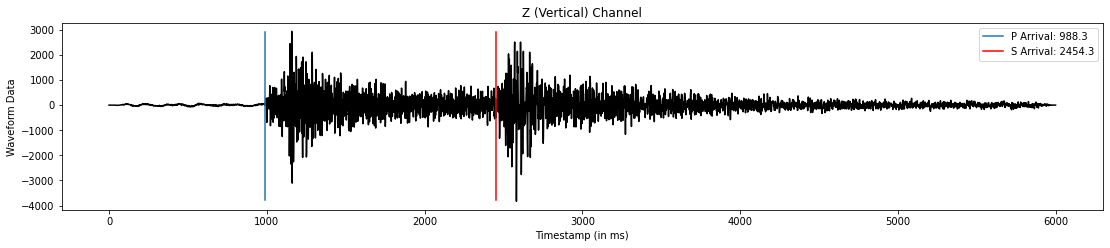

index: 10
key: JAGI.GE_20081011045445_EV | p-wave: 1060.3 | s-wave: 2468.3
index: 11
key: JAGI.GE_20081111194102_EV | p-wave: 739.06 | s-wave: 2051.06
index: 12
key: SOEI.GE_20090810230006_EV | p-wave: 600.0 | s-wave: 2081.0
index: 13
key: UGM.GE_20071118192333_EV | p-wave: 1029.0 | s-wave: 1629.0
index: 14
key: UGM.GE_20090117165742_EV | p-wave: 944.3 | s-wave: 1248.3
index: 15
key: UGM.GE_20090608004445_EV | p-wave: 919.0 | s-wave: 1228.0
index: 16
key: UGM.GE_20090822130029_EV | p-wave: 964.5 | s-wave: 1173.5


In [20]:
for index, (key, signal) in enumerate(npz_dict.items()):
    print(f'index: {index}')
    print(f"key: {key} | p-wave: {df_earthquake_near_indonesia.loc[index, 'p_arrival_sample']} | s-wave: {df_earthquake_near_indonesia.loc[index, 's_arrival_sample']}")

#     plot_channel_waveform(signal, waveform_max=signal.shape[0], index_channel=[2],
#                          p_arrival=df_earthquake_near_indonesia.loc[index, 'p_arrival_sample'],
#                          s_arrival=df_earthquake_near_indonesia.loc[index, 's_arrival_sample'])
    if index == 9:
        waveform_1_sample = signal.copy()
        plot_channel_waveform(signal, waveform_max=signal.shape[0], index_channel=[2],
                         p_arrival=df_earthquake_near_indonesia.loc[index, 'p_arrival_sample'],
                         s_arrival=df_earthquake_near_indonesia.loc[index, 's_arrival_sample'])
    
    print('=========================================================')

In [21]:
print(waveform_1_sample.shape)

waveform_additional = waveform_1_sample[:900].copy()
waveform_additional = np.repeat(waveform_additional, 4, axis=0)
print(waveform_additional.shape)
# waveform_additional = np.concatenate((waveform_additional, waveform_additional[:300]), axis=0)

waveform_1_sample = np.concatenate((waveform_additional, waveform_1_sample), axis=0)
print(waveform_1_sample.shape)

(6000, 3)
(3600, 3)
(9600, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


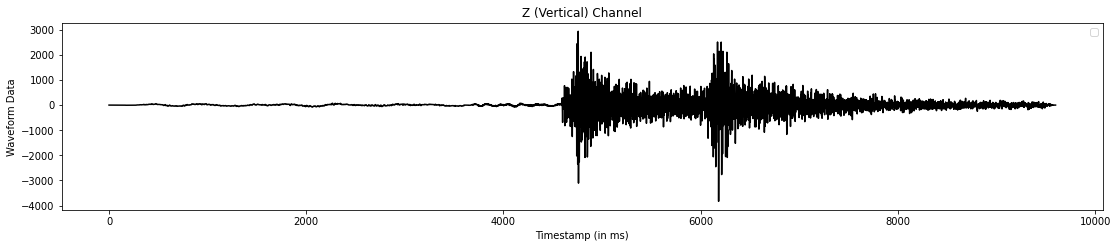

In [22]:
plot_channel_waveform(waveform_1_sample, waveform_max=waveform_1_sample.shape[0], index_channel=[2])

In [23]:
np.savez_compressed('./Data/stead_indonesia_single_wavelength.npz', waveform_1_sample)

### Save File

In [39]:
# np.savez_compressed('./Data/stead_indonesia_wavelength.npz', indonesia_earthquake_waveform)
with open('./Data/stead_indonesia_wavelength.json', 'wb') as fp:
    pkl.dump(npz_dict, fp)

In [40]:
df_earthquake_near_indonesia.to_csv('./Data/stead_indonesia_metadata.csv', index=False)